# Basic Tutorial

This notebook illustrates a basic application of the Mellon density estimator on scRNA-seq data.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import palantir
import mellon
import scanpy as sc

In [2]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

## Loading the data

We use a publically available scRNA-seq dataset of T-cell depleted bone marrow.

In [3]:
ad_url = "https://zenodo.org/record/6383269/files/bm_multiome_rna.h5ad"
ad = sc.read("data/bm_multiome_rna.h5ad", backup_url=ad_url)

# Preprocessing

The loaded annData was already processed from raw gene counts according to
https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb
and comes with celltype annotations, pca, and a umap representation.
We use diffusion map representation to clean up the cell-state representation.

In [4]:
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values

Determing nearest neighbor graph...


## Compute pseudotime (optional)

Pseudotime is not required for the density computation. Howeever, it can be insightful to
investigate cell-state density fluctuation along temporal trajectories such as cell-differentiation.

In [5]:
celltype = 'HSPC'
for dcomp in range(ad.obsm['DM_EigenVectors'].shape[1]):
    ec = ad.obsm['DM_EigenVectors'][:, dcomp].argmax()
    if ad.obs['celltype'][ec] == celltype:
        mm = 'maximum'
        break
    ec = ad.obsm['DM_EigenVectors'][:, dcomp].argmin()
    if ad.obs['celltype'][ec] == celltype:
        mm = 'minimum'
        break
else: # no break
    raise Exception('No valid component found.')
early_cell = ad.obs_names[ec]
print(f'Using {early_cell} as early cell which is the {mm} of diffusion component {dcomp}.')

Using IM-1393_BoneMarrow_TcellDep_2_multiome#AGCCGCTAGACAAGTG-1 as early cell which is the maximum of diffusion component 5.


Sampling and flocking waypoints...
Time for determining waypoints: 0.015990734100341797 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.26976213455200193 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


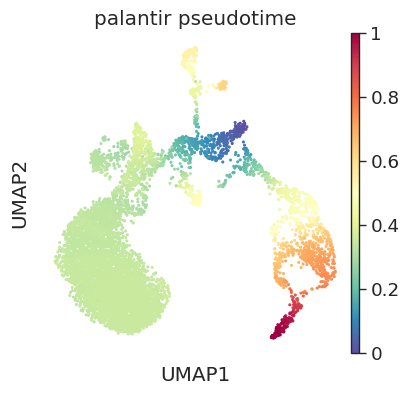

In [6]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)
pl_res = palantir.core.run_palantir(ms_data, early_cell)
ad.obs['palantir_pseudotime'] = pl_res.pseudotime
sc.pl.scatter(ad, basis='umap', color=['palantir_pseudotime'], size=20)

# Density computation

In [7]:
%%time
model = mellon.DensityEstimator()
log_density = model.fit_predict(ad.obsm['DM_EigenVectors'])
ad.obs['log_density'] = log_density
ad.obs['log_density_clipped'] = np.clip(log_density, *np.quantile(log_density, [.05, 1]))

CPU times: user 3min 29s, sys: 13.2 s, total: 3min 42s
Wall time: 21.4 s


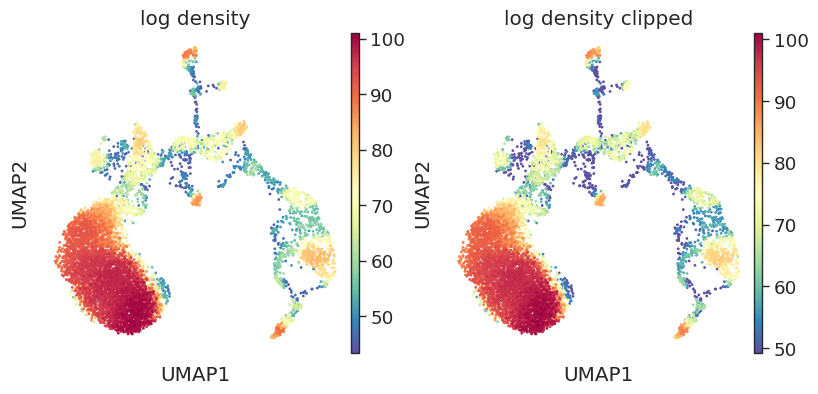

In [8]:
sc.pl.scatter(ad, color=['log_density', 'log_density_clipped'], basis='umap')

# Example analysis

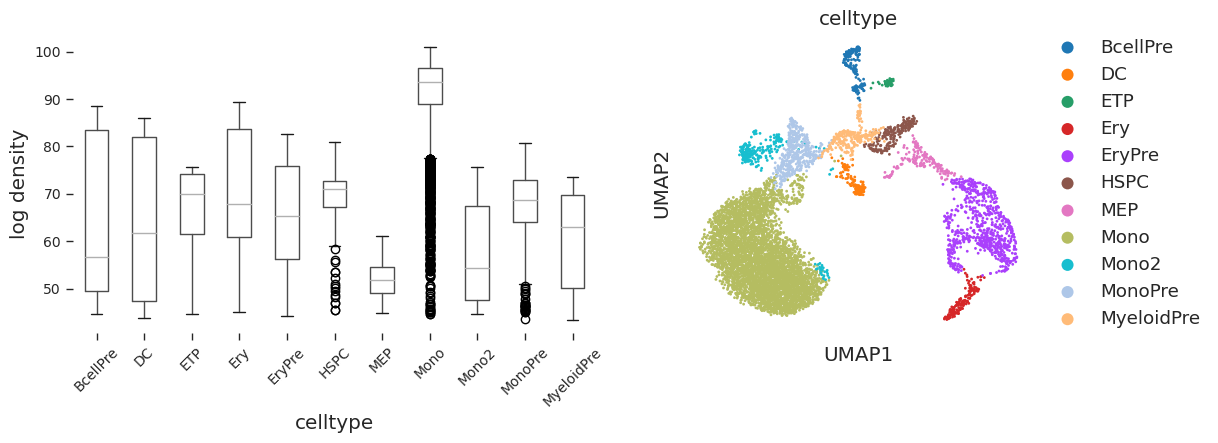

In [9]:
matplotlib.rcParams['figure.figsize'] = [12, 4]
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2])
ad.obs.boxplot('log_density', by='celltype', grid=False, rot=45, fontsize=10, ax=ax1)
fig.suptitle('')
ax1.set_title('')
ax1.set_ylabel('log density')
sc.pl.scatter(ad, color='celltype', basis='umap', ax=ax2)
plt.show()

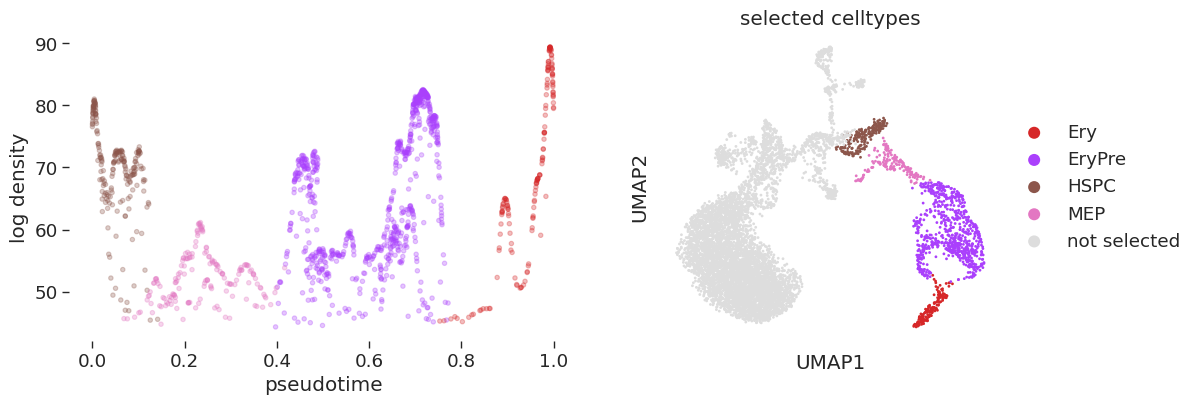

In [10]:
selection = ['HSPC', 'MEP', 'EryPre', 'Ery']

matplotlib.rcParams['figure.figsize'] = [12, 4]
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2])

ct_colors = ad.uns.get(
    'ct_colors',
    dict(zip(ad.obs['celltype'].cat.categories, ad.uns['celltype_colors'])),
)
sct_colors = {ct:ct_colors[ct] for ct in selection}
sct_colors['not selected'] = '#DDDDDD'
idx = ad.obs['celltype'].isin(selection)
color_vec = [sct_colors[ct] for ct in ad.obs.loc[idx, 'celltype']]
ad.obs['selected_celltypes'] = ad.obs['celltype'].astype(str).where(idx, 'not selected').astype('category')
ad.uns['selected_celltypes_colors'] = [sct_colors[c] for c in ad.obs['selected_celltypes'].cat.categories]
scatter = ax1.scatter(ad.obs.loc[idx, 'palantir_pseudotime'], ad.obs.loc[idx, 'log_density'], c=color_vec, s=10, alpha=.3)
ax1.set_xlabel('pseudotime')
ax1.set_ylabel('log density')
sc.pl.scatter(ad, color='selected_celltypes', basis='umap', ax=ax2)
plt.show()

# Adjustable parameters

Above, all parameters are set automatically. In the following equivalent code
and parameters can be changed as desired. The input for Mellon is a
state representation of cells `X`.

In [11]:
X = ad.obsm['DM_EigenVectors']
nn_distances = mellon.compute_nn_distances(X)

The `length_scale` regulates the smoothness of the resulting density function.
A lower value produces a faster changing more detailed and therefore less stable result.
By default Mellon selects the length scale based on a huristic that aims to maximixe
the posterio likelihood of the resulting density function.

In [12]:
length_scale = mellon.compute_ls(nn_distances)

Landmarks in the data are used to approximate the covariance structure and hence the similarity of density values between cells by using the similarity to the landmarks as proxy. While any set of landmarks can be used, k-means-cluster centroids preformed best in our tests. The number of landmarks limits the rank of the resulting covariance matrix.

In [13]:
%%time
n_landmarks = 5000
landmarks = mellon.k_means(X, n_landmarks, n_init=1)[0]

CPU times: user 34.4 s, sys: 1.01 s, total: 35.5 s
Wall time: 2.22 s


By default, we further reduce the rank of the covariance matrix with an improved Nyström approximation. The rank parameter can be used to either select the fraction of total variance (sum of eigenvalues) preserved or an integer number of ranks. The resulting L is a Cholesky factor of the approximated covariance matrix.

In [14]:
%%time
rank = 0.999
cov_func = mellon.Matern52(length_scale)
L = mellon.compute_L(X, cov_func, landmarks=landmarks, rank=rank)

CPU times: user 2min 37s, sys: 12.8 s, total: 2min 50s
Wall time: 11.5 s


By default, we assume that the data can vary along all its dimensions. However, if it is known that locally cells vary only along a subspace, e.g., tangential to the phenotypic manifold, then the dimensionality of this subspace should be used. d is used to correctly related the nearest-neighbor-distance distribution to the cell-state density.

In [15]:
d = X.shape[1]

Mellon can automatically suggest a mean value mu for the Gaussian process of log-density to ensure scale invariance. A low value ensures that the density drops of quickly away from the data.

In [16]:
mu = mellon.compute_mu(nn_distances, d)

An initial value, based on ridge regression, is used by default to speed up the optimization.

In [17]:
%%time
initial_parameters = mellon.compute_initial_value(nn_distances, d, mu, L)

model = mellon.DensityEstimator(
    nn_distances=nn_distances,
    d=d,
    mu=mu,
    cov_func=cov_func,
    L=L,
    initial_value=initial_parameters,
)

log_density = model.fit_predict(X)

CPU times: user 43.7 s, sys: 1.13 s, total: 44.8 s
Wall time: 6.55 s


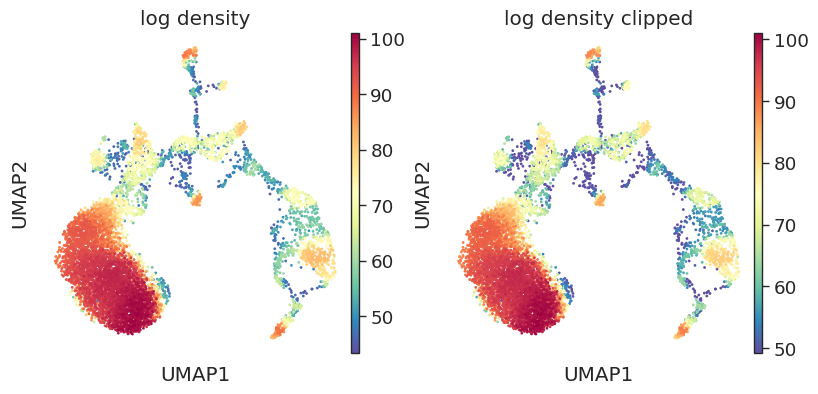

In [19]:
matplotlib.rcParams['figure.figsize'] = [4, 4]
ad.obs['log_density'] = log_density
ad.obs['log_density_clipped'] = np.clip(log_density, *np.quantile(log_density, [.05, 1]))
sc.pl.scatter(ad, color=['log_density', 'log_density_clipped'], basis='umap')